In [48]:
using DrWatson
@quickactivate "gaussian_process_jl"

In [113]:
using Revise

# example Gaussian Process following a post on discord
# https://discourse.julialang.org/t/gaussian-process-model-with-turing/42453/9

# Import Libraries
using Turing
using Turing: Variational
using Distributions
using Distances
using StatsFuns
import Random
using Flux
import LinearAlgebra

# Utility Libraries
using Parameters
using IterTools

# Plotting Libraries
using CairoMakie
using GLMakie

# set theme for Makie
set_theme!(theme_ggplot2())
Makie.inline!(true)

true

In [50]:
# Here you may include files from the source directory
# include(srcdir("gaussian_process.jl"))

In [51]:
# function definitions
function quantiles(X, q; dims, drop=false)
    Q = mapslices(x -> quantile(x, q), X, dims=dims)
    out = drop ? dropdims(Q, dims=dims) : Q
    return out
end

# To extract parameters from ADVI model.
function make_extractor(m, q, nsamples=1000)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges=Val(true))
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end

# Squared-exponential covariance function
sqexp_cov_fn(D, phi, eps=1e-3) = exp.(-D^2 / phi) + LinearAlgebra.I * eps

# Exponential covariance function
exp_cov_fn(D, phi) = exp.(-D / phi)


exp_cov_fn (generic function with 1 method)

In [52]:
@model function GP(y, X, m=0, s=1, cov_fn=exp_cov_fn)
    # Dimensions of predictors .
    N, P = size(X)

    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)

    # Priors.
    mu ~ Normal(m, s)
    sig2 ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 1)

    # Realized covariance function
    K = cov_fn(D, phi)

    # Sampling Distribution.
    # The latent variables have been marginalized out here,
    # so there's only one layer. Note that when N is large,
    # this model will be really slow. There are several ways to speed up.
    # 1. Use a low-rank approximation (e.g. predictive process).
    #    This can scale to potentially N=50000. Haven't tried it myself, but I 
    #    believe this shuold be doable in Turing.
    # 2. GP for Big Data: https://arxiv.org/abs/1309.6835
    y ~ MvNormal(mu * ones(N), K + sig2 * LinearAlgebra.I(N))
end


GP (generic function with 5 methods)

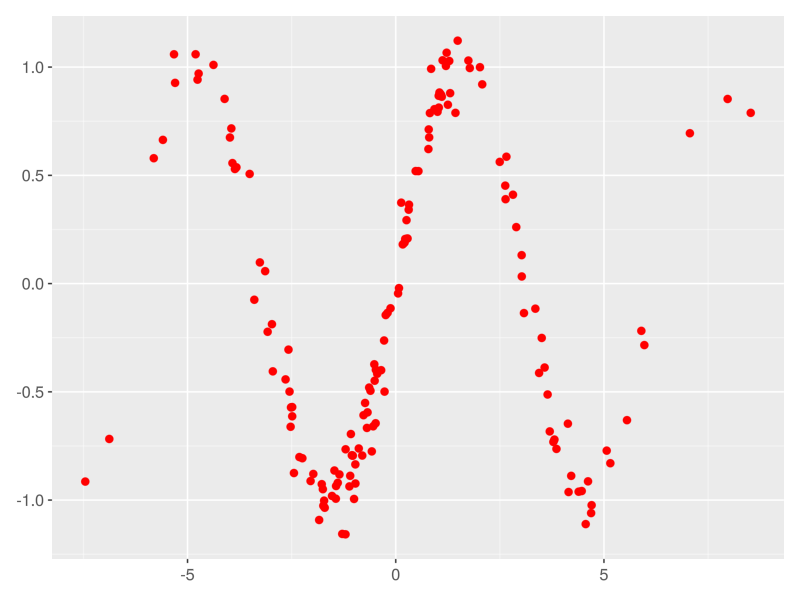

In [53]:
# Generate some non-linear data
Data = @with_kw (
    N=150,
    X=randn(N, 1) * 3,
    y=sin.(vec(X)) + randn(N) * 0.1
)

# =====================================================================
# init data
data = Data()
fig = Figure()
plot(fig[1, 1], vec(data.X), data.y, color=:red)
fig


In [54]:
# Fit via ADVI. You can also use HMC.
# Random.seed!(0)
# m = GP(data.y, data.X)
# q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
# advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
# @time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-1));


In [91]:
ModelPrior = @with_kw (mu = 0, sig2=1, phi=0.5)
prior = ModelPrior()


(mu = 0, sig2 = 1, phi = 0.5)

In [ ]:
# Fit via HMC.
Random.seed!(0)
chain = sample(GP(data.y, data.X, mu=prior.mu, s=prior.sig2), HMC(0.01, 100), 200)


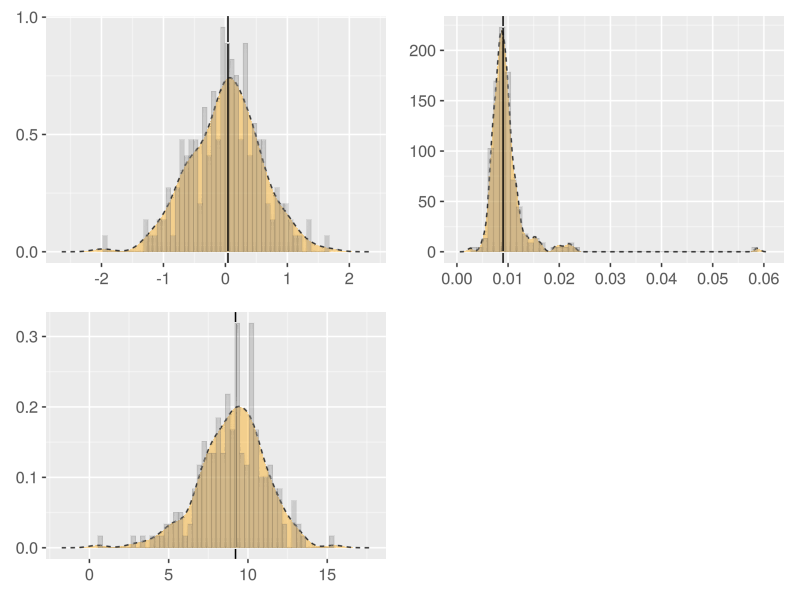

In [109]:
fig = Figure()

for (loc, var) in zip([[1,1],[1,2],[2,1]], [:mu, :sig2, :phi])
    ax = Axis(fig[loc...])
    density!(ax, vec(chain[var]), strokewidth = 1.5, color=(:orange, 0.4), strokecolor = :grey20, linestyle = :dash)
    hist!(ax, vec(chain[var]), bins=50, strokewidth=0.1, color=(:gray, 0.3), normalization=:pdf)
    vlines!(ax, median(vec(chain[var])), color="black")
end

fig


In [57]:
# Get posterior samples
# extract_gp = make_extractor(m, q)
# mu = vec(extract_gp(:mu))
# sig2 = vec(extract_gp(:sig2))
# phi = vec(extract_gp(:phi));

# For HMC:
mu = group(chain, :mu).value.data[:, :, 1]
sig2 = group(chain, :sig2).value.data[:, :, 1]
phi = group(chain, :phi).value.data[:, :, 1];


In [58]:

# This funciton returns a function for predicting at new points given parameter values.
function make_gp_predict_fn(Xnew, y, X, cov_fn)
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D = pairwise(Euclidean(), Z, dims=1)

    return (mu, sig2, phi) -> let
        K = cov_fn(D, phi)
        Koo_inv = inv(K[(M+1):end, (M+1):end])
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * (y .- mu) .+ mu
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        mvn = MvNormal(m, S + sig2 * LinearAlgebra.I)
        rand(mvn)
    end
end


# Make predictions at new locations.
Xnew = sort(randn(data.N, 1) * 4, dims=1)
gp_predict = make_gp_predict_fn(Xnew, data.y, data.X, exp_cov_fn)
ynew = [gp_predict(mu[m], sig2[m], phi[m]) for m in 1:length(mu)]
ynew = hcat(ynew...);


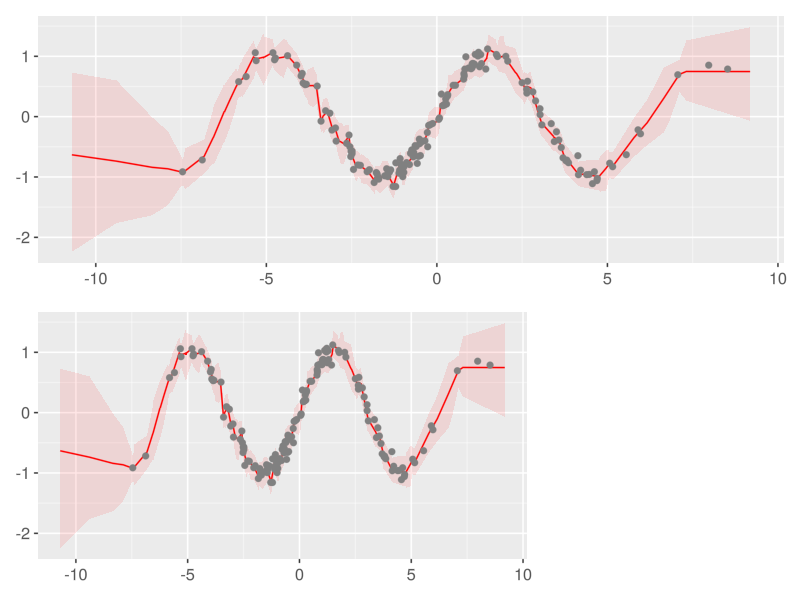

In [59]:
# Plot predictions
pred_mean = mean(ynew, dims=2)
pred_lower = quantiles(ynew, 0.025, dims=2)
pred_upper = quantiles(ynew, 0.975, dims=2)

fig = Figure()

ax = Axis(fig[1, 1:3])
fill_between!(ax, vec(Xnew), vec(pred_upper), vec(pred_lower), color=(:red,0.1))
lines!(ax, vec(Xnew), vec(pred_mean), color="red", label="Posterior predictive mean")
scatter!(ax, vec(data.X), vec(data.y), color="grey", label="Data", markersize=10)

ax = Axis(fig[2, 1:2])
fill_between!(ax, vec(Xnew), vec(pred_upper), vec(pred_lower), color=(:red,0.1))
lines!(ax, vec(Xnew), vec(pred_mean), color="red", label="Posterior predictive mean")
scatter!(ax, vec(data.X), vec(data.y), color="grey", label="Data", markersize=10)

fig


# plt.plot(vec(Xnew), vec(pred_mean), color="red", label="Posterior predictive mean")
# plt.scatter(vec(X), vec(y), color="grey", label="Data")
# plt.fill_between(vec(Xnew), vec(pred_upper), vec(pred_lower), color="red", alpha=0.2)
# plt.legend(loc="lower right")
# plt.title("GP Posterior predictive with 95% credible interval");
